In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import pickle
import xgboost as xgb
import tigramite
from tigramite.pcmci import PCMCI
from tigramite import data_processing as pp
from tigramite.independence_tests.parcorr import ParCorr
import seaborn as sns

In [5]:
PROJ_ROOT = '/Users/madelineloui/Documents/STAR/Sofar/SOFAR'

### Load pre-trained models
Autoencoder

In [16]:
df = pd.read_csv(f'{PROJ_ROOT}/data/simulated/fault_final.csv')
data = df.to_numpy()[:,:-3]
data_size = data.shape[1]

In [231]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(data_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28, 8),
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, data_size),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [232]:
ae = AE()
ae.load_state_dict(torch.load(f'{PROJ_ROOT}/models/ae_final.pt'))

<All keys matched successfully>

Gaussian Mixture Model

In [233]:
with open(f'{PROJ_ROOT}/models/gmm_final.pkl', 'rb') as file:
    gmm = pickle.load(file)
    file.close()

Kalman Filter

In [234]:
class KalmanFilter():
    def __init__(self, beta, R, Q):
        """
        Initialize the Kalman Filter.
        """
        self.beta = beta
        self.M = len(beta) #number of old temp measurements to keep
        self.x_hat = np.zeros(self.M) #predicted state variable
        self.P = np.zeros((self.M, self.M)) #state covariance matrix
        self.R = R #measurement noise
        self.Q = Q #process noise
        self.F = np.block([
            [np.eye(self.M)[1:]],
            [self.beta.T]
            ]) #transition matrix
        self.H = np.block([
            [np.zeros(self.M-1), np.array([1])]
            ])
    
    def update(self, sensor_update):
        """
        Update the state based on the
        sensor inputs.
        """
        #Prediction step (update state + cov based on dynamics)
        x_hat_pred = self.F@self.x_hat
        P_pred = self.F@self.P@self.F.T + self.Q
        
        #Update step (update based on sensor measurement)
        innovation_residual = sensor_update-self.H@x_hat_pred
        S = self.H@P_pred@self.H.T + self.R
        K = P_pred@self.H.T@np.linalg.inv(S)
        x_hat_update = x_hat_pred + K@innovation_residual
        P_update = (np.eye(self.M)-K@self.H)@P_pred
        post_fit_residual = sensor_update-self.H@x_hat_update
        
        self.x_hat = x_hat_update
        self.P = P_update
        self.S = S
        #For some reason, IMM depends on innovation residual
        #rather than post-fit
        self.residual = innovation_residual
    
    def get_state_estimate(self):
        return self.x_hat
    
    def get_residual(self):
        return self.residual
    
    def get_residual_covariance(self):
        return self.S

In [235]:
# Predict and update Kalman Filters with data, return residual error
def KF_data(kfs, data):
    res = np.zeros((data.shape))
    bar = tqdm.tqdm(total=len(data))
    for i, d in enumerate(data):
        # Predict and update with sensor measurement
        for j in range(len(kfs)):
            kfs[j].update(d[j])
            res[i,j] = kfs[j].get_residual()
        bar.update()
    bar.close()
    return res

In [236]:
with open(f'{PROJ_ROOT}/models/kf_final.pkl', 'rb') as file:
    kf = pickle.load(file)
    file.close()

LSTM

In [237]:
class simpleLSTM(nn.Module):
    def __init__(self, data_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=data_dim, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, data_dim)
    def forward(self, x):
        #print(x.shape)
        x, _ = self.lstm(x)
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        #print()
        return x

In [238]:
lstm = simpleLSTM(data_size)
lstm.load_state_dict(torch.load(f'{PROJ_ROOT}/models/lstm_final.pt'))

<All keys matched successfully>

PCMCI

In [39]:
def run_pcmci(data, pc_alpha=0.01, tau_max=1):
    parcorr = ParCorr(significance='analytic')
    results = []
    bar = tqdm.tqdm(total=len(data))
    for d in data:
        dataframe = pp.DataFrame(d)
        pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=0)
        pcmci_out = pcmci.run_pcmci(pc_alpha=pc_alpha, tau_max=tau_max)
        results.append(pcmci_out['val_matrix'][:,:,tau_max])
        bar.update()
    bar.close()
    return results

### Format test data

In [9]:
# Load data
df = pd.read_csv(f'{PROJ_ROOT}/data/fault_final.csv')
all_data = df.to_numpy()

In [10]:
def format_data(dataset, lookback=None, normalize=True):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    if normalize:
        # Normalize each variable
        min_vals = np.amin(dataset, axis=0)
        max_vals = np.amax(dataset, axis=0)
        min_arr = np.repeat(np.expand_dims(min_vals, axis=0), len(dataset), axis=0)
        max_arr = np.repeat(np.expand_dims(max_vals, axis=0), len(dataset), axis=0)
        dataset = (dataset-min_arr)/(max_arr-min_arr)
    
    if lookback is not None:
        dataset = np.array([dataset[i:i+lookback] for i in range(len(dataset)-lookback)])
    
    return dataset

In [11]:
# Create input and labels
test_data = all_data[:,:-3].astype(float)
fault_present = all_data[:,-3]
attributes = all_data[:,-2]

### ADJUSTABLE ###
window = 20

# AE use normalized raw data
ae_data = torch.from_numpy(format_data(test_data)[window:]).type('torch.FloatTensor') #buffer for window
print(ae_data.shape)

# LSTM use normalized past 20 time steps 
lstm_data = torch.from_numpy(format_data(test_data, lookback=window)).clone().detach().float()
print(lstm_data.shape)

# KF and GMM use raw data
kf_data = test_data[window:] #buffer for window
print(kf_data.shape)
gmm_data = test_data[window:] #buffer for window
print(gmm_data.shape)

# PCMCI use windows of raw data, subsample for once every 10 seconds
# Sample rate is 10/s, so subsample by 10*10s = 100
pcmci_data = format_data(test_data, lookback=window, normalize=False)
pc_ss = 100
pcmci_data = pcmci_data[::pc_ss]
print(pcmci_data.shape)

torch.Size([105101, 15])
torch.Size([105101, 20, 15])
(105101, 15)
(105101, 15)
(1052, 20, 15)


### Pass through ensemble detection models

In [262]:
# Autoencoder
ae_out = ae(ae_data)
ae_err = ae_out - ae_data
ae_err = ae_err.detach().numpy()
print(ae_err.shape)
np.save(f'{PROJ_ROOT}/models/ensemble_outputs/ae_err.npy', ae_err)

(105101, 15)


In [263]:
# GMM
gmm_score = gmm.score_samples(gmm_data)
print(gmm_score.shape)
np.save(f'{PROJ_ROOT}/models/ensemble_outputs/gmm_score.npy', gmm_score)

(105101,)


In [264]:
# Kalman Filter
kf_res = KF_data(kf, kf_data)
print(kf_res.shape)
np.save(f'{PROJ_ROOT}/models/ensemble_outputs/kf_res.npy', kf_res)


 15%|████▉                             | 15324/105101 [00:09<00:55, 1603.76it/s]


 29%|█████████▉                        | 30895/105101 [00:19<00:46, 1597.62it/s]


 44%|███████████████                   | 46372/105101 [00:29<00:36, 1599.21it/s]


 59%|████████████████████              | 61933/105101 [00:39<00:27, 1585.61it/s]


 74%|█████████████████████████         | 77399/105101 [00:48<00:17, 1569.20it/s]


 88%|██████████████████████████████    | 92945/105101 [00:58<00:07, 1619.36it/s]


100%|█████████████████████████████████| 105101/105101 [01:06<00:00, 1587.84it/s]


(105101, 15)


In [265]:
# LSTM
loss_fn = nn.MSELoss()
lstm_loss = []
bar = tqdm.tqdm(total=(len(lstm_data)))
for lstm_d in lstm_data:
    out = lstm(lstm_d)
    lstm_loss.append(loss_fn(out, lstm_d).detach().numpy())
    bar.update()
bar.close()
lstm_loss = np.array(lstm_loss)
print(lstm_loss.shape)
np.save(f'{PROJ_ROOT}/models/ensemble_outputs/lstm_loss.npy', lstm_loss)


 23%|███████▉                          | 39119/166798 [19:30<1:03:38, 33.43it/s]

 15%|█████▏                            | 15987/105101 [00:11<00:51, 1720.23it/s]


 31%|██████████▌                       | 32506/105101 [00:22<00:34, 2101.66it/s]


 48%|████████████████▊                  | 50559/105101 [00:34<00:56, 960.98it/s]


 65%|██████████████████████            | 68021/105101 [00:45<00:21, 1725.67it/s]


 83%|████████████████████████████▏     | 87197/105101 [00:56<00:10, 1650.93it/s]


100%|█████████████████████████████████| 105101/105101 [01:07<00:00, 1562.62it/s]


(105101,)


In [71]:
# PCMCI
pcmci_out = run_pcmci(pcmci_data)

  0%|                                          | 1/1052 [00:00<07:03,  2.48it/s]/Users/mloui/anaconda3/envs/sofar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
  1%|▍                                        | 11/1052 [00:04<06:42,  2.59it/s]/Users/mloui/anaconda3/envs/sofar/lib/python3.10/site-packages/tigramite-5.2.0.0-py3.10.egg/tigramite/independence_tests/parcorr.py:100: UserWarning: Possibly constant array!
/Users/mloui/anaconda3/envs/sofar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))
100%|███████████████████████████████████████| 1052/1052 [07:23<00:00,  2.37it/s]


In [40]:
# Upsample back to original data size
pcmci_result = np.repeat(np.expand_dims(pcmci_out[0].flatten(), axis=0), pc_ss, axis=0)
bar = tqdm.tqdm(total=len(pcmci_out)-1)
for out in pcmci_out[1:]:
    pcmci_result = np.concatenate((pcmci_result, np.repeat(np.expand_dims(out.flatten(), axis=0), pc_ss, axis=0)))
    bar.update()
bar.close()
print(pcmci_result.shape)

pcmci_result = np.nan_to_num(pcmci_result)
pcmci_result = pcmci_result[:len(gmm_data)]
print(pcmci_result.shape)
np.save(f'{PROJ_ROOT}/models/ensemble_outputs/pcmci_result.npy', pcmci_result)

  1%|▍                                          | 2/176 [00:02<03:01,  1.04s/it]/Users/mloui/anaconda3/envs/sofar/lib/python3.10/site-packages/tigramite-5.2.0.0-py3.10.egg/tigramite/independence_tests/parcorr.py:100: UserWarning: Possibly constant array!
/Users/mloui/anaconda3/envs/sofar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/mloui/anaconda3/envs/sofar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))
100%|█████████████████████████████████████████| 175/175 [00:08<00:00, 21.26it/s]


(105600, 225)
(105101, 225)


In [80]:
# Reduce dimensionality of pcmci result
n_pcmci = 3

pcmci_small = np.repeat(np.expand_dims(np.argsort(pcmci_out[0], axis=1)[:,-n_pcmci:].flatten(), axis=0), pc_ss, axis=0)
bar = tqdm.tqdm(total=len(pcmci_out)-1)
for out in pcmci_out[1:]:
    pcmci_small = np.concatenate((pcmci_small, np.repeat(np.expand_dims(np.argsort(out, axis=1)[:,-n_pcmci:].flatten(), axis=0), pc_ss, axis=0)))
    bar.update()
bar.close()

pcmci_small = np.nan_to_num(pcmci_small)
pcmci_small = pcmci_small[:len(gmm_data)]
print(pcmci_small.shape)
np.save(f'{PROJ_ROOT}/models/ensemble_outputs/pcmci_small.npy', pcmci_small)

100%|██████████████████████████████████████| 1051/1051 [00:05<00:00, 180.45it/s]


(105101, 45)


### Create training data for xgboost

In [6]:
# Optional: Load ensemble outputs
ae_err = np.load(f'{PROJ_ROOT}/models/ensemble_outputs/ae_err.npy')
gmm_score = np.load(f'{PROJ_ROOT}/models/ensemble_outputs/gmm_score.npy')
kf_res = np.load(f'{PROJ_ROOT}/models/ensemble_outputs/kf_res.npy')
lstm_loss = np.load(f'{PROJ_ROOT}/models/ensemble_outputs/lstm_loss.npy')
pcmci_result = np.load(f'{PROJ_ROOT}/models/ensemble_outputs/pcmci_small.npy')

In [7]:
print(ae_err.shape)
print(gmm_score.shape)
print(kf_res.shape)
print(lstm_loss.shape)
print(pcmci_result.shape)

(105101, 15)
(105101,)
(105101, 15)
(105101,)
(105101, 45)


In [20]:
# X: Input consists of raw data (current time step) and outputs of the AE, KF, GMM, LSTM
# Don't necessarily need to normalize x
x = test_data[window:]
x = x.reshape((len(x),-1))
print(x.shape)
x = np.block([x, ae_err, np.expand_dims(gmm_score,axis=1), kf_res, np.expand_dims(lstm_loss,axis=1), pcmci_result]).astype(float)
print(x.shape)

(105101, 15)
(105101, 92)


In [21]:
# Y: Attributes as number labels
attributes = all_data[:,-2]
fault_present = all_data[:,-3]
label_num = {'No fault':0, 'IRF_R':1, 'IRF_S':2, 'IRF_Z':3, 'K_H':4, 'K_F':5, 'K_L':6, 'K_C':7, 'I_O':8,
             'I_U':9, 'SR_clock_resets_at_zero_on_reset':10, 'SR_clock_jumps_to_later_time_on_reset':11}
y = np.zeros(len(all_data))
y[fault_present==0] = label_num['No fault']
for key in label_num:
    if key=='No fault':
        print(f'{key}: {np.sum(fault_present==0)}')
    else:
        print(f'{key}: {np.sum(attributes==key)}')
    y[attributes==key] = label_num[key]
y = y[window:].astype(int)
print(len(y))

No fault: 71653
IRF_R: 2197
IRF_S: 7213
IRF_Z: 2292
K_H: 3704
K_F: 3509
K_L: 2458
K_C: 5173
I_O: 1894
I_U: 4943
SR_clock_resets_at_zero_on_reset: 40
SR_clock_jumps_to_later_time_on_reset: 45
105101


### Train xgboost

In [22]:
# Split data into train and test sets
seed = 7
test_size = 0.25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

(78825, 92)
(78825,)
(26276, 92)
(26276,)


In [86]:
# Sweep params
#max_depth = [3,6,9]
max_depth = [6]

for md in max_depth:
        
    print('---------------------------')
    print(f'Training with depth {md}')

    # Specify parameters
    param = {"max_depth": md, "eta": 0.1, "num_class": 12, "objective": "multi:softprob"}

    # Specify validations set to watch performance
    watchlist = [(dtrain, "train"), (dtest, "eval")]
    
    evals_result = {}

    # Train with specified number of boosting rounds
    bst = xgb.train(param, dtrain, num_boost_round=100, early_stopping_rounds=20, evals=watchlist, evals_result=evals_result) #num_boost_round=num_round

    # test loss
    preds = bst.predict(dtest)
    labels = dtest.get_label()
    print(f'Final test loss: {log_loss(y_test, preds)}')

    # Save model
    bst.save_model('xgb_model.json')
    bst.dump_model('xgb_model.txt')
    pickle.dump(bst, open('xgb_model.pkl', 'wb'))
    
    # Save lossess
    pickle.dump(evals_result, open('xgb_loss.pkl', 'wb'))

---------------------------
Training with depth 6
[0]	train-mlogloss:1.94667	eval-mlogloss:1.94605
[1]	train-mlogloss:1.64237	eval-mlogloss:1.64163
[2]	train-mlogloss:1.42581	eval-mlogloss:1.42462
[3]	train-mlogloss:1.25746	eval-mlogloss:1.25624
[4]	train-mlogloss:1.12055	eval-mlogloss:1.11932
[5]	train-mlogloss:1.00516	eval-mlogloss:1.00389
[6]	train-mlogloss:0.90136	eval-mlogloss:0.90058
[7]	train-mlogloss:0.81240	eval-mlogloss:0.81171
[8]	train-mlogloss:0.73445	eval-mlogloss:0.73419
[9]	train-mlogloss:0.66525	eval-mlogloss:0.66508
[10]	train-mlogloss:0.60343	eval-mlogloss:0.60323
[11]	train-mlogloss:0.54660	eval-mlogloss:0.54650
[12]	train-mlogloss:0.49748	eval-mlogloss:0.49753
[13]	train-mlogloss:0.45295	eval-mlogloss:0.45311
[14]	train-mlogloss:0.41287	eval-mlogloss:0.41313
[15]	train-mlogloss:0.37722	eval-mlogloss:0.37760
[16]	train-mlogloss:0.34526	eval-mlogloss:0.34573
[17]	train-mlogloss:0.31616	eval-mlogloss:0.31684
[18]	train-mlogloss:0.28986	eval-mlogloss:0.29063
[19]	train

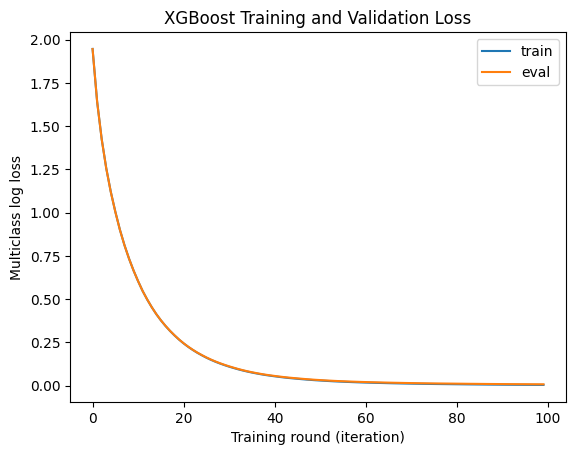

In [87]:
# Plot eval results
train_loss = evals_result['train']['mlogloss']
eval_loss = evals_result['eval']['mlogloss']
plt.plot(train_loss, label='train')
plt.plot(eval_loss, label='eval')
plt.xlabel('Training round (iteration)')
plt.ylabel('Multiclass log loss')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
# Plot tree
#fig, ax = plt.subplots(figsize=(30, 30))
#xgb.plot_tree(bst, num_trees=4, ax=ax)

In [13]:
#from sklearn import tree
#tree.plot_tree(bst)

In [1]:
# TODO - See which features are most important
#print(bst.get_fscore())

In [88]:
import networkx as nx

df = bst.trees_to_dataframe()
print(df[:10])

# Create graph
G = nx.Graph()
# Add all the nodes
G.add_nodes_from(df.ID.tolist())
# Add the edges. This should be simpler in Pandas, but there seems to be a bug with df.apply(tuple, axis=1) at the moment.
yes_pairs = df[['ID', 'Yes']].dropna()
no_pairs = df[['ID', 'No']].dropna()
yes_edges = [tuple([i[0], i[1]]) for i in yes_pairs.values]
no_edges = [tuple([i[0], i[1]]) for i in no_pairs.values]
G.add_edges_from(yes_edges + no_edges)
print(G)

#nx.draw(G)

   Tree  Node   ID Feature      Split   Yes    No Missing          Gain  \
0     0     0  0-0     f30 -27.422655   0-1   0-2     0-1  41052.562500   
1     0     1  0-1     f30 -28.771807   0-3   0-4     0-3     31.570587   
2     0     2  0-2     f91  13.500000   0-5   0-6     0-5  16957.406200   
3     0     3  0-3     f25   0.684915   0-7   0-8     0-7      0.839661   
4     0     4  0-4     f20   0.072009   0-9  0-10     0-9     50.082573   
5     0     5  0-5     f49   0.500000  0-11  0-12    0-11  12067.418000   
6     0     6  0-6      f4   0.062501  0-13  0-14    0-13    768.156250   
7     0     7  0-7     f30 -29.079636  0-15  0-16    0-15      0.577728   
8     0     8  0-8    Leaf        NaN   NaN   NaN     NaN      0.020134   
9     0     9  0-9      f2   3.176761  0-17  0-18    0-17      4.672246   

          Cover  Category  
0  12042.709000       NaN  
1   1781.083500       NaN  
2  10261.626000       NaN  
3   1767.791870       NaN  
4     13.291668       NaN  
5   43

### Evaluate

In [17]:
# Optional: load xgb model from directory
xgb_model = xgb.Booster()
xgb_model.load_model(f'{PROJ_ROOT}/models/xgboost/xgb_model.json')

In [14]:
# Or use model trained here
#xgb_model = bst

In [23]:
# Predict
y_pred = xgb_model.predict(dtest) #predicted class probabilities
print(y_pred.shape)
labels_pred = np.argmax(y_pred, axis=1).astype(int) #predicted class labels
print(labels_pred.shape)

(26276, 12)
(26276,)


In [24]:
accuracy = np.sum(labels_pred==y_test)/len(y_test)*100
print("Overall accuracy: %.4f%%" % (accuracy))

# Detection
detection_acc = np.sum(labels_pred[y_test!=0] != 0)/np.sum(y_test!=0)*100
tp = np.sum(labels_pred[y_test!=0] != 0)
tn = np.sum(labels_pred[y_test==0] == 0)
fp = np.sum(labels_pred[y_test==0] != 0)
fn = np.sum(labels_pred[y_test!=0] == 0)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)
print('Fault detection:')
det_acc = (tp+tn)/(tp+tn+fp+fn)
print(f'Detection accuracy: {det_acc*100:.4f}')
print(f'TPR: {tpr*100:.6f}\nFNR: {fnr*100:.6f}\nTNR: {tnr*100:.6f}\nFPR: {fpr*100:.6f}')

# TODO
#attribution_acc = np.sum(labels_pred[y_test!=0] == y_test[y_test!=0])*100
#print("Fault attribution accuracy: %.2f%%" % (attribution_acc))

Overall accuracy: 99.8934%
Fault detection:
Detection accuracy: 99.9353
TPR: 99.878891
FNR: 0.121109
TNR: 99.961152
FPR: 0.038848


In [26]:
# Accuracy
tpr_all = []
fnr_all = []
tnr_all = []
fpr_all = []
att_acc_all = []
det_att_acc_all = []
for key in label_num:
    if key=='No fault':
        print(f'{key}: {np.sum(y_test==0)}')
    else:
        print(f'{key}: {np.sum(y_test==label_num[key])}')
    label_true = np.zeros(len(y_test))
    label_true[y_test==label_num[key]] = 1
    label_pred = np.zeros(len(labels_pred))
    label_pred[labels_pred==label_num[key]] = 1
    
    # Accuracy
    acc = (np.sum(label_true==label_pred)/len(label_pred))*100
    
    if key != 'No fault':
        # TP, FP...
        det_p = np.all(np.stack((y_test==label_num[key],labels_pred!=0)).T, axis=1)
        det_n = np.all(np.stack((y_test!=label_num[key],labels_pred!=0)).T, axis=1)
        att_tp = int(np.sum(label_pred[det_p]))
        att_fp = int(np.sum(label_pred[det_n]))
        att_tn = int(np.sum(label_pred[det_n]==0))
        att_fn = int(np.sum(label_pred[det_p]==0))
        print(f'TP: {att_tp}\nFP: {att_fp}\nTN: {att_tn}\nFN: {att_fn}')
        
        att_tpr = att_tp/(att_tp+att_fn)
        att_fnr = att_fn/(att_tp+att_fn)
        att_tnr = att_tn/(att_tn+att_fp)
        att_fpr = att_fp/(att_tn+att_fp)
        tpr_all.append(att_tpr)
        fnr_all.append(att_fnr)
        tnr_all.append(att_tnr)
        fpr_all.append(att_fpr)
        print(f'TPR: {att_tpr*100:.4f}\nFNR: {att_fnr*100:.4f}\nTNR: {att_tnr*100:.4f}\nFPR: {att_fpr*100:.4f}')
        
        att_acc = (att_tp+att_tn)/(att_tp+att_tn+att_fp+att_fn)
        att_acc_all.append(att_acc*100)
        print(f'Attribution accuracy: {att_acc:.4f}')
        
        det_att_tp = np.sum(label_pred[label_true==1] == 1)/np.sum(label_true==1)*100
        det_att_tn = np.sum(label_pred[label_true==0] == 0)/np.sum(label_true==0)*100
        det_att_fp = np.sum(label_pred[label_true==0] == 1)/np.sum(label_true==1)*100
        det_att_fn = np.sum(label_pred[label_true==1] == 0)/np.sum(label_true==1)*100
        det_att_acc = (det_att_tp+det_att_tn)/(det_att_tp+det_att_tn+det_att_fp+det_att_fn)
        det_att_acc_all.append(det_att_acc*100)
            
        print(f'Detection and attribution accuracy: {det_att_acc:.4f}')
        print()
    else:
        print()
    
# Fault attribution
avg_att_acc = np.sum(np.array(att_acc_all))/11
print(f'Average fault attribution accuracy: {avg_att_acc:.4f}')
avg_det_att = np.sum(np.array(det_att_acc_all))/11
print(f'Average fault detection and attribution accuracy for faulting case: {avg_det_att:.4f}')


No fault: 18019

IRF_R: 563
TP: 554
FP: 1
TN: 7692
FN: 7
TPR: 98.7522
FNR: 1.2478
TNR: 99.9870
FPR: 0.0130
Attribution accuracy: 0.9990
Detection and attribution accuracy: 0.9911

IRF_S: 1706
TP: 1704
FP: 2
TN: 6548
FN: 0
TPR: 100.0000
FNR: 0.0000
TNR: 99.9695
FPR: 0.0305
Attribution accuracy: 0.9998
Detection and attribution accuracy: 0.9988

IRF_Z: 561
TP: 560
FP: 2
TN: 7692
FN: 0
TPR: 100.0000
FNR: 0.0000
TNR: 99.9740
FPR: 0.0260
Attribution accuracy: 0.9998
Detection and attribution accuracy: 0.9973

K_H: 937
TP: 937
FP: 3
TN: 7314
FN: 0
TPR: 100.0000
FNR: 0.0000
TNR: 99.9590
FPR: 0.0410
Attribution accuracy: 0.9996
Detection and attribution accuracy: 0.9984

K_F: 861
TP: 857
FP: 0
TN: 7394
FN: 3
TPR: 99.6512
FNR: 0.3488
TNR: 100.0000
FPR: 0.0000
Attribution accuracy: 0.9996
Detection and attribution accuracy: 0.9977

K_L: 602
TP: 602
FP: 2
TN: 7650
FN: 0
TPR: 100.0000
FNR: 0.0000
TNR: 99.9739
FPR: 0.0261
Attribution accuracy: 0.9998
Detection and attribution accuracy: 0.9983

K_C:

In [27]:
tpr_all=np.array(tpr_all)
avg_tpr = np.sum(tpr_all)/11
print(f'Average fault attribution TPR: {avg_tpr*100:.4f}%|')

fnr_all=np.array(fnr_all)
avg_fnr = np.sum(fnr_all)/11
print(f'Average fault attribution FNR: {avg_fnr*100:.4f}%|')

tnr_all=np.array(tnr_all)
avg_tnr = np.sum(tnr_all)/11
print(f'Average fault attribution TNR: {avg_tnr*100:.4f}%|')

fpr_all=np.array(fpr_all)
avg_fpr = np.sum(fpr_all)/11
print(f'Average fault attribution FPR: {avg_fpr*100:.4f}%|')

Average fault attribution TPR: 99.8477%|
Average fault attribution FNR: 0.1523%|
Average fault attribution TNR: 99.9772%|
Average fault attribution FPR: 0.0228%|


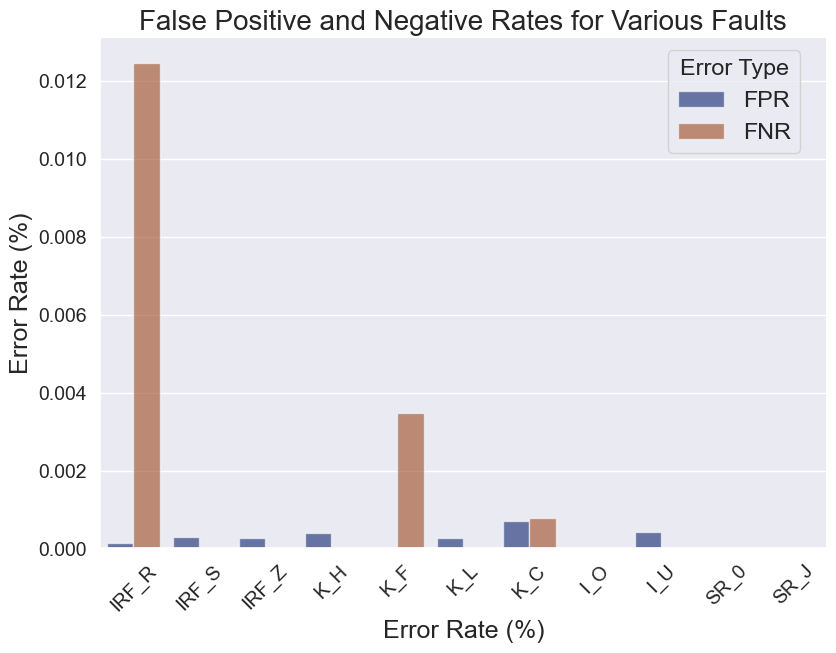

In [56]:
# Plot FNR and FPR
metrics_df = pd.DataFrame()
metrics_df['Error Rate'] = np.concatenate((fpr_all, fnr_all))
type_list = []
for i in range(11):
    type_list.append('FPR')
for i in range(11):
    type_list.append('FNR')
metrics_df['Error Type'] = type_list
new_labels = list(label_num.keys())[1:-2]
new_labels.append('SR_0')
new_labels.append('SR_J')
metrics_df['Fault'] = np.concatenate((new_labels, new_labels))
#print(metrics_df)

# Set the font scale for Seaborn
sns.set(rc={'figure.figsize':(10,6), 'font.size': 14})

# Your data and plot code
plot = sns.catplot(
    data=metrics_df, kind='bar',
    x='Fault', y='Error Rate', hue='Error Type',
    errorbar="sd", palette="dark", alpha=.6, height=6, aspect=1.4, legend_out=False)

# Move legend inside the plot
plt.legend(title='Error Type', loc='upper right', bbox_to_anchor=(0.98, 1), fontsize='large', title_fontsize='large')

plt.title('False Positive and Negative Rates for Various Faults', fontsize=20)
plt.ylabel('Error Rate (%)', fontsize=18)
plt.xlabel('Error Rate (%)', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plot.savefig('error.png', bbox_inches='tight')

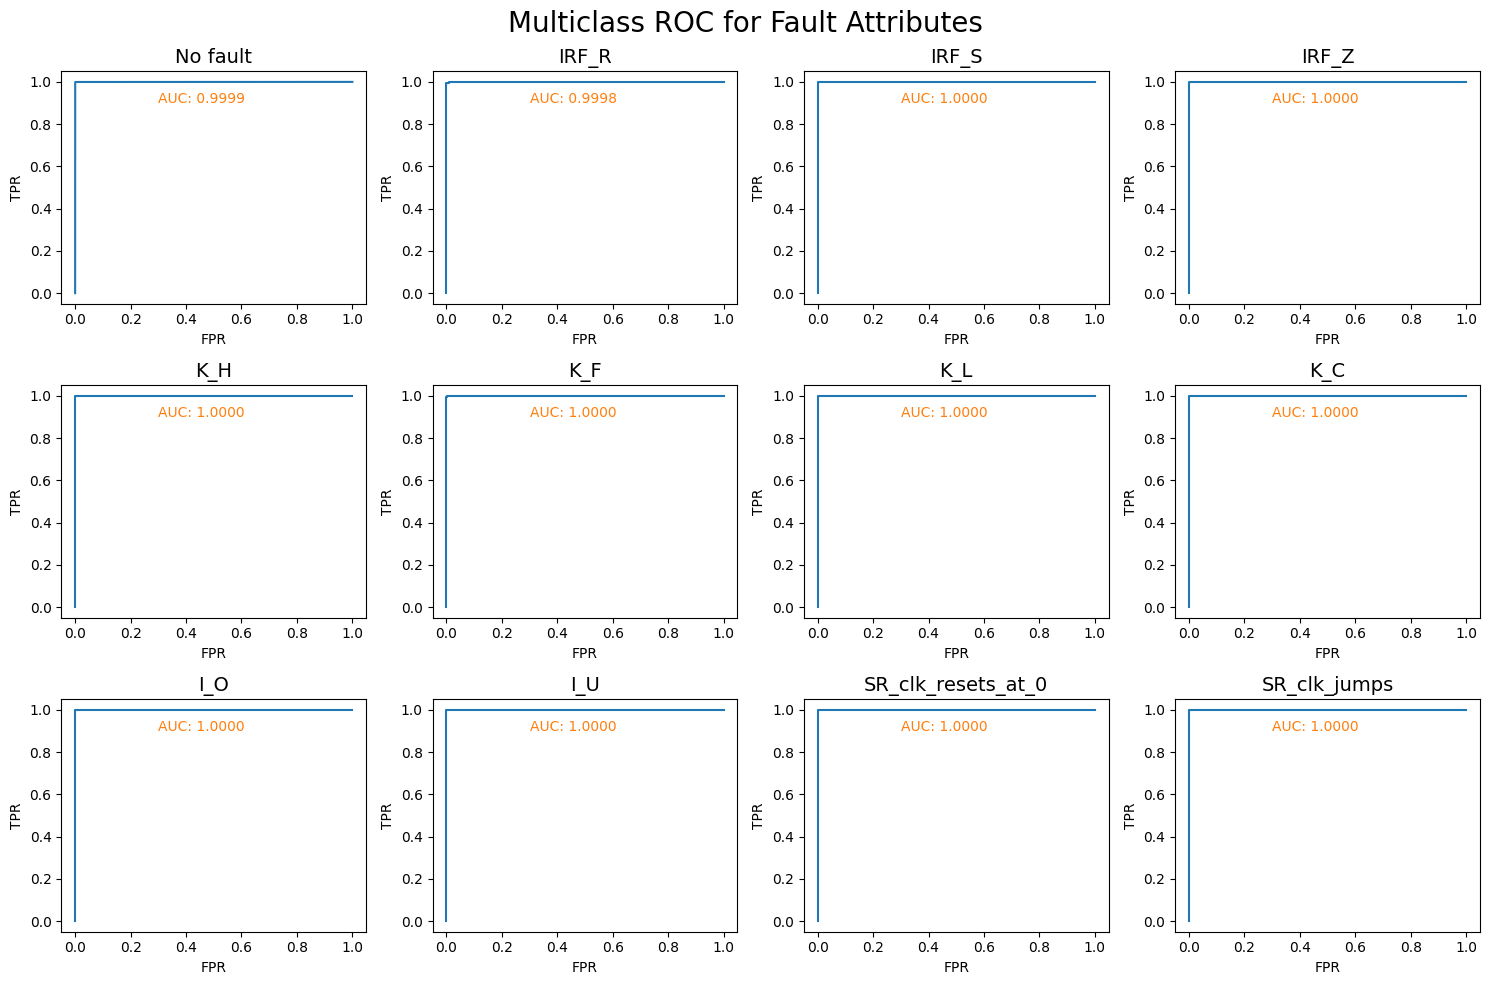

In [95]:
# ROC
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
ax_num = 0
for key in label_num:
    label_true = np.zeros(len(y_test))
    label_true[y_test==label_num[key]] = 1
    label_pred = np.zeros(len(labels_pred))
    label_pred[labels_pred==label_num[key]] = 1
    
    # ROC
    prob = y_pred[:,label_num[key]]
    fpr, tpr, thres = roc_curve(label_true, prob)
    auc = roc_auc_score(label_true, prob)
    #print(f'AUC: {auc:.4f}')
    
    r = int(math.floor(ax_num)/4)
    c = ax_num%4
    ax[r,c].plot(fpr, tpr)
    if key == 'SR_clock_resets_at_zero_on_reset':
        key = 'SR_clk_resets_at_0'
    if key == 'SR_clock_jumps_to_later_time_on_reset':
        key = 'SR_clk_jumps'
    ax[r,c].set_title(key, fontsize=14)
    ax[r,c].text(0.3, 0.9, f'AUC: {auc:.4f}', color='tab:orange', fontsize = 10)
    ax[r,c].set_xlabel('FPR')
    ax[r,c].set_ylabel('TPR')
    
    ax_num+=1
    
    '''
    # Plot
    plt.figure()
    plt.plot(fpr, tpr)
    if key == 'SR_clock_resets_at_zero_on_reset':
        key = 'SR_clk_resets_at_0'
    if key == 'SR_clock_jumps_to_later_time_on_reset':
        key = 'SR_clk_jumps'
    plt.title(f'ROC for {key}')
    plt.text(0.4, 0.15, f'AUC: {auc:.4f}', color='tab:orange', fontsize = 10)
    plt.show()
    '''
fig.suptitle('Multiclass ROC for Fault Attributes', fontsize=20)
fig.tight_layout()
plt.show()

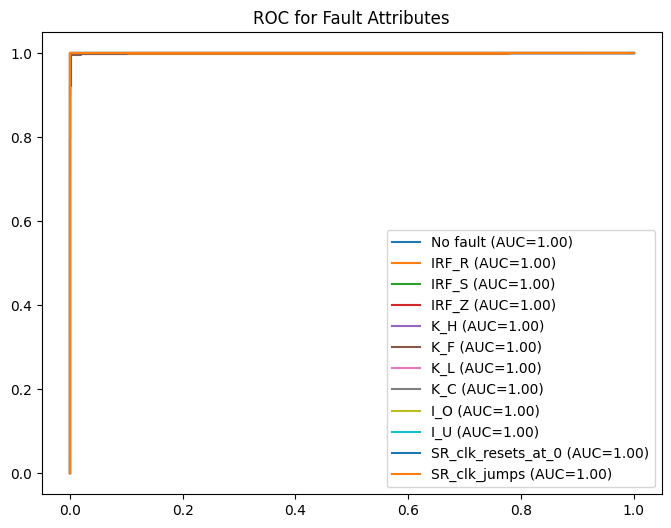

In [339]:
# ROC all on same plot
figure(figsize=(8,6))
for key in label_num:
    label_true = np.zeros(len(y_test))
    label_true[y_test==label_num[key]] = 1
    label_pred = np.zeros(len(labels_pred))
    label_pred[labels_pred==label_num[key]] = 1
    
    # ROC
    prob = y_pred[:,label_num[key]]
    fpr, tpr, thres = roc_curve(label_true, prob)
    auc = roc_auc_score(label_true, prob)
    #print(f'AUC: {auc:.4f}')
    
    if key == 'SR_clock_resets_at_zero_on_reset':
        key = 'SR_clk_resets_at_0'
    if key == 'SR_clock_jumps_to_later_time_on_reset':
        key = 'SR_clk_jumps'
    plt.plot(fpr, tpr, label=f'{key} (AUC={auc:.2f})')
    
plt.title(f'ROC for Fault Attributes')
plt.legend()
plt.show()

In [287]:
# Investigate SR_clock_resets_at_zero_on_reset
label_id = label_num['SR_clock_resets_at_zero_on_reset']
print(label_id)
print(labels_pred[y_test == label_id])
# Sometimes misses, thinks no fault there

10
[ 0  0  0  0 10  0 10 10 10 10 10 10  0]
